# Blob Analysis

The past two activities taught you how to segment a region of interest according to grayscale or 
color, and how to clean up a thresholded image using morphological operations. Let us assume you 
have succeeded in getting a clean segmented binary image, where white blobs of connected pixels 
are the regions of interest and black pixels are the background. In this activity, we learn how to 
**extract features** from these blobs.

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from matplotlib.patches import Rectangle
from skimage import measure
from scipy.ndimage import binary_dilation, binary_erosion, binary_closing, binary_opening

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
# plt.rcParams["text.usetex"] = True

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## Image segmentation

Codes adapted for parametric and nonparametric segmentation from the previous activities

In [4]:
def NCC(img):
    img = img/255
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    I = R + G + B
    I[I == 0] = 100000
    r, g = R/I, G/I
    b = 1 - r - g
    return r, g, b

In [5]:
def gaussian_PDF(orig_img, roi_img):
    mu = np.mean(roi_img)
    sigma = np.std(roi_img)
    gaussian = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(orig_img - mu)**2/(2*sigma**2))
    return gaussian

In [6]:
def parametric_segmentation(orig_img, roi_img):
    orig_img_red = gaussian_PDF(NCC(orig_img)[0], NCC(roi_img)[0])
    orig_img_green = gaussian_PDF(NCC(orig_img)[1], NCC(roi_img)[1])
    segmented_img = orig_img_red * orig_img_green
    return segmented_img

In [7]:
def nonparametric_segmentation(orig_img, roi_img, bins):
    
    r_orig = (NCC(orig_img)[0]*(bins-1)).astype(int)
    g_orig = (NCC(orig_img)[1]*(bins-1)).astype(int)
    r_roi = (NCC(roi_img)[0]*(bins-1)).astype(int)
    g_roi = (NCC(roi_img)[1]*(bins-1)).astype(int)
    
    img_matrix, xbins, ybins = np.histogram2d(g_roi.flatten(), r_roi.flatten(), 
                                                    bins = bins, range = [[0, bins], [0, bins]])
    
    # iterate all rows and columns of segmented_img
    # array of zeros with same shape as roi_img - basis image!
    segmented_img = np.zeros(NCC(orig_img)[0].shape)
    for i in range(NCC(orig_img)[0].shape[0]): 
        for j in range(NCC(orig_img)[0].shape[1]):
            segmented_img[i,j] = img_matrix[g_orig[i,j], r_orig[i,j]]
            
    return segmented_img

## Structuring elements

Adapted from the previous activity on morphological operations

In [3]:
# Structuring elements
square_5 = np.zeros((11, 11))
square_5[3:8, 3:8] = 1

square_5s = np.zeros((11, 11))
square_5s[3:8, 3:8] = 1

## Sample blobs

We have done feature extraction using ImageJ. Now we will use MATLAB or python functions to integrate the feature extraction in our program. We may want to do this if we need to do experiments repeatedly.


In [8]:
def rgb2gray(filename):
    rgbimg = Image.open(filename + ".png")
    grayimg = np.array(rgbimg.convert("L"))
    return grayimg

In [18]:
def rgb_img(filename):
    orig_img = Image.open(filename + ".png")
    rgb_img = np.array(orig_img.convert("RGB"))
    return rgb_img

In [23]:
malaria = rgb2gray("malaria")
malaria_RGB = rgb_img("malaria")
malaria_ROI = rgb_img("malaria ROI")
malaria_threshold = (malaria > 100) & (malaria < 160)

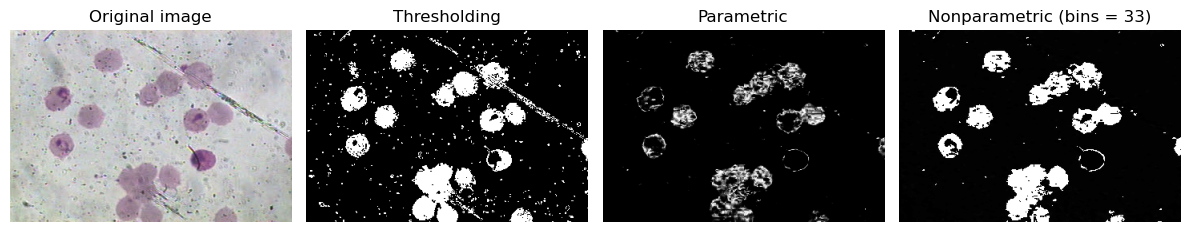

In [78]:
fig, ax = plt.subplots(1, 4, figsize = (12, 4), tight_layout = True)

ax[0].imshow(malaria_RGB)
ax[0].set_title("Original image")
ax[1].imshow(malaria_threshold, cmap = "gray")
ax[1].set_title("Thresholding")
ax[2].imshow(parametric_segmentation(malaria_RGB, malaria_ROI), cmap = "gray")
ax[2].set_title("Parametric")
ax[3].imshow(nonparametric_segmentation(malaria_RGB, malaria_ROI, 33), cmap = "gray")
ax[3].set_title("Nonparametric (bins = 33)")

for a in ax:
    a.axis("off")

Performing morphological cleaning on the thresholded image as it retained most of the shape of the cell,

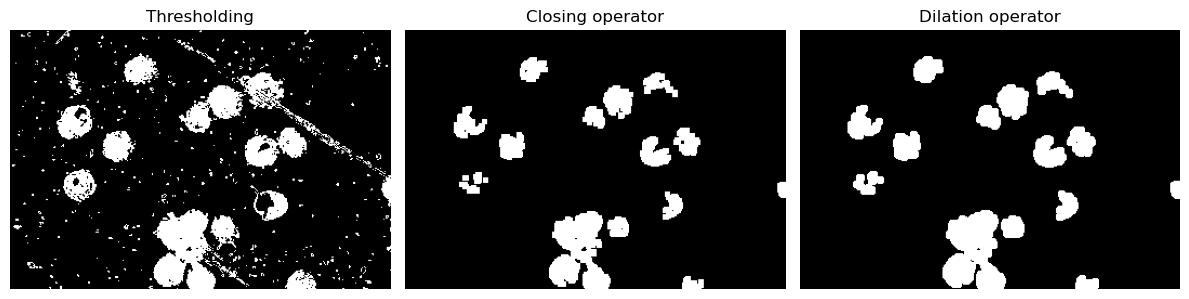

In [85]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), tight_layout = True)

ax[0].imshow(malaria_threshold, cmap = "gray")
ax[0].set_title("Thresholding")
ax[1].imshow(binary_opening(malaria_threshold, square_5), cmap = "gray")
ax[1].set_title("Closing operator")
ax[2].imshow(binary_dilation(binary_opening(malaria_threshold, square_5)), cmap = "gray")
ax[2].set_title("Dilation operator")

for a in ax:
    a.axis("off")

In [99]:
malaria_cleaned = binary_dilation(binary_opening(malaria_threshold, square_5))
malaria_labels = measure.label(malaria_cleaned)
malaria_props = measure.regionprops(malaria_labels)

In [125]:
# Regionprops cell parameters
malaria_label = []
malaria_centroid = []
malaria_area = []

In [126]:
counter = 1

for prop in malaria_props:
    malaria_label.append(prop.label)
    malaria_centroid.append(prop.centroid)
    malaria_area.append(prop.area)
    counter += 1

In [137]:
malaria_results = measure.regionprops_table(malaria_labels, properties = ("area", "centroid", ))
pd.DataFrame(malaria_results)

,area,centroid-0,centroid-1
0,516,36.868217,117.598837
1,498,50.847390,234.118474
2,731,66.376197,196.852257
3,647,87.445131,57.914992
4,391,81.038363,174.514066
5,535,103.788785,260.056075
6,580,107.643103,98.406897
7,643,114.083981,229.779160
8,390,141.658974,62.494872
9,137,147.664234,347.372263
